In [44]:
# install this libraries 
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library(RCurl)

# Classification Analysis: Predicting Hepatitis C And Its Progression

**Introduction:**

   Hepatitis C is a liver inflammation caused by the Hepatitis C Virus (HCV). It is frequently asymptotic at first, resulting in many patients being unaware of the disease. Despite the fact that doctors urge that adults over the age of 18 get tested at least once in their lives, many people still do not get a Hepatitis C test until or even after they have symptoms, and there are still many undiagnosed patients. Thus, predicting if a person has HCV using currently accessible laboratory data can help to reduce the number of undiagnosed patients. Moreover, Hepatitis C can progress into more severe diagnoses like Fibrosis or Cirrhosis, thus being able to predict weather patient has regular Hepatitis C, Fibrosis or Cirrhosis can add more benefits to our analysis.
   
    Question: Based on data in HCV data set, does the patient have Hepatitis C, and if so, what is the progress of it?
    
   For this study, we will use HCV data from the Machine Learning repository at UC Irvine. The data set contains laboratory results from patients with Hepatitis C and blood donors, who do not have Hepatitis C, together with their demographic data like age or gender.

1) X (Patient ID/No.)
2) Category (diagnosis) (values: '0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis')
3) Age (in years)
4) Sex (f,m)
5) ALB - Albumin Blood Test
6) ALP - Alkaline phosphatase
7) ALT - Alanine Transaminase
8) AST - Aspartate Transaminase
9) BIL - Bilirubin
10) CHE - Acetylcholinesterase
11) CHOL - Cholesterol
12) CREA - Creatinine
13) GGT - Gamma-Glutamyl Transferase
14) PROT - Proteins

**Preliminary exploratory data analysis:**

In [45]:
#reading data
url <- "https://raw.githubusercontent.com/lilitvanyan/DS_Group_Project/a224c6f2fced1023c1047768fc54fe5aecd9c1bb/hcvdat0.csv"
data <- getURL(url)
hcv_data <- read_csv(data)

hcv_data <- hcv_data |>
mutate(Index = ...1) |>
select(-...1)
head(hcv_data)

New names:
• `` -> `...1`
Rows: 615 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Category, Sex
dbl (12): ...1, Age, ALB, ALP, ALT, AST, BIL, CHE, CHOL, CREA, GGT, PROT

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Index
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106,12.1,69.0,1
0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74,15.6,76.5,2
0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86,33.2,79.3,3
0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80,33.8,75.7,4
0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76,29.9,68.7,5
0=Blood Donor,32,m,41.6,43.3,18.5,19.7,12.3,9.92,6.05,111,91.0,74.0,6


In [66]:
#wrangling data and splitting data set to have training data
hcv_split <- hcv_data |>
mutate(Category = as.factor(Category)) |>
filter(Category != "0s=suspect Blood Donor")|> #we don't need this category for this analysis
mutate(Category = fct_recode(Category, 
                             "Blood Donor" = "0=Blood Donor", 
                             "Hepatitis"="1=Hepatitis", 
                             "Fibrosis"="2=Fibrosis", 
                             "Cirrhosis"="3=Cirrhosis"))|>
initial_split(prop = 0.75, strata = Category)

hcv_train <- training(hcv_split)
head(hcv_train)

Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Index
<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106,12.1,69.0,1
Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74,15.6,76.5,2
Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86,33.2,79.3,3
Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76,29.9,68.7,5
Blood Donor,32,m,46.3,41.3,17.5,17.8,8.5,7.01,4.79,70,16.9,74.5,7
Blood Donor,32,m,42.2,41.9,35.8,31.1,16.1,5.82,4.60,109,21.5,67.1,8


In [67]:
#Summarizing general information about data
hcv_summary <- hcv_train |> 
summarize(row_count = n(), 
          col_count = ncol(hcv_train),
          na_count = sum(rowSums(is.na(hcv_train))>0)) |>
pivot_longer(row_count:na_count, names_to = "statistics", values_to = "count")
hcv_summary

statistics,count
<chr>,<int>
row_count,456
col_count,14
na_count,17


In [68]:
#mean value of each lab result grouped by category
hcv_lab_summary <- hcv_train |> 
group_by(Category) |>
summarize(ALB_mean = mean(ALB, na.rm = TRUE),
          ALP_mean = mean(ALP, na.rm = TRUE),
          AST_mean = mean(AST, na.rm = TRUE),
          BIL_mean = mean(BIL, na.rm = TRUE),
          CHE_mean = mean(CHE, na.rm = TRUE),
          CHOL_mean = mean(CHOL, na.rm = TRUE),
          CREA_mean = mean(CREA, na.rm = TRUE),
          GGT_mean = mean(GGT, na.rm = TRUE),
          PROT_mean = mean(PROT, na.rm = TRUE)) 
hcv_lab_summary

Category,ALB_mean,ALP_mean,AST_mean,BIL_mean,CHE_mean,CHOL_mean,CREA_mean,GGT_mean,PROT_mean
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Blood Donor,42.09035,67.98292,26.36411,8.327723,8.417129,5.447688,78.61386,28.75421,71.98441
Hepatitis,44.10526,44.22941,82.35263,15.421053,9.010000,4.829474,75.97895,102.63684,74.40526
Fibrosis,41.38462,36.83750,90.66923,14.307692,8.322308,4.602500,71.08462,69.96154,74.24615
Cirrhosis,31.78947,99.43529,118.60000,57.050000,3.772000,4.034737,93.14500,145.31500,69.49500


The table above displays the mean of each lab result based on the category, allowing us to see how the mean value of each lab result changes when the patient's diagnosis changes.

In [69]:
hcv_category_summary <- hcv_train |> 
summarize(Blood_Donor = nrow((filter(hcv_train, Category == "Blood Donor"))), 
          Hepatitis = nrow((filter(hcv_train, Category == "Hepatitis"))), 
          Fibrosis = nrow((filter(hcv_train, Category == "Fibrosis"))), 
          Cirrhosis = nrow((filter(hcv_train, Category == "Cirrhosis")))) |>
pivot_longer(Blood_Donor:Cirrhosis, names_to = "Diagnose", values_to = "Count")
hcv_category_summary

Diagnose,Count
<chr>,<int>
Blood_Donor,404
Hepatitis,19
Fibrosis,13
Cirrhosis,20


Finally, the table above shows the number of observations for each category, showing that the data isn't balanced.

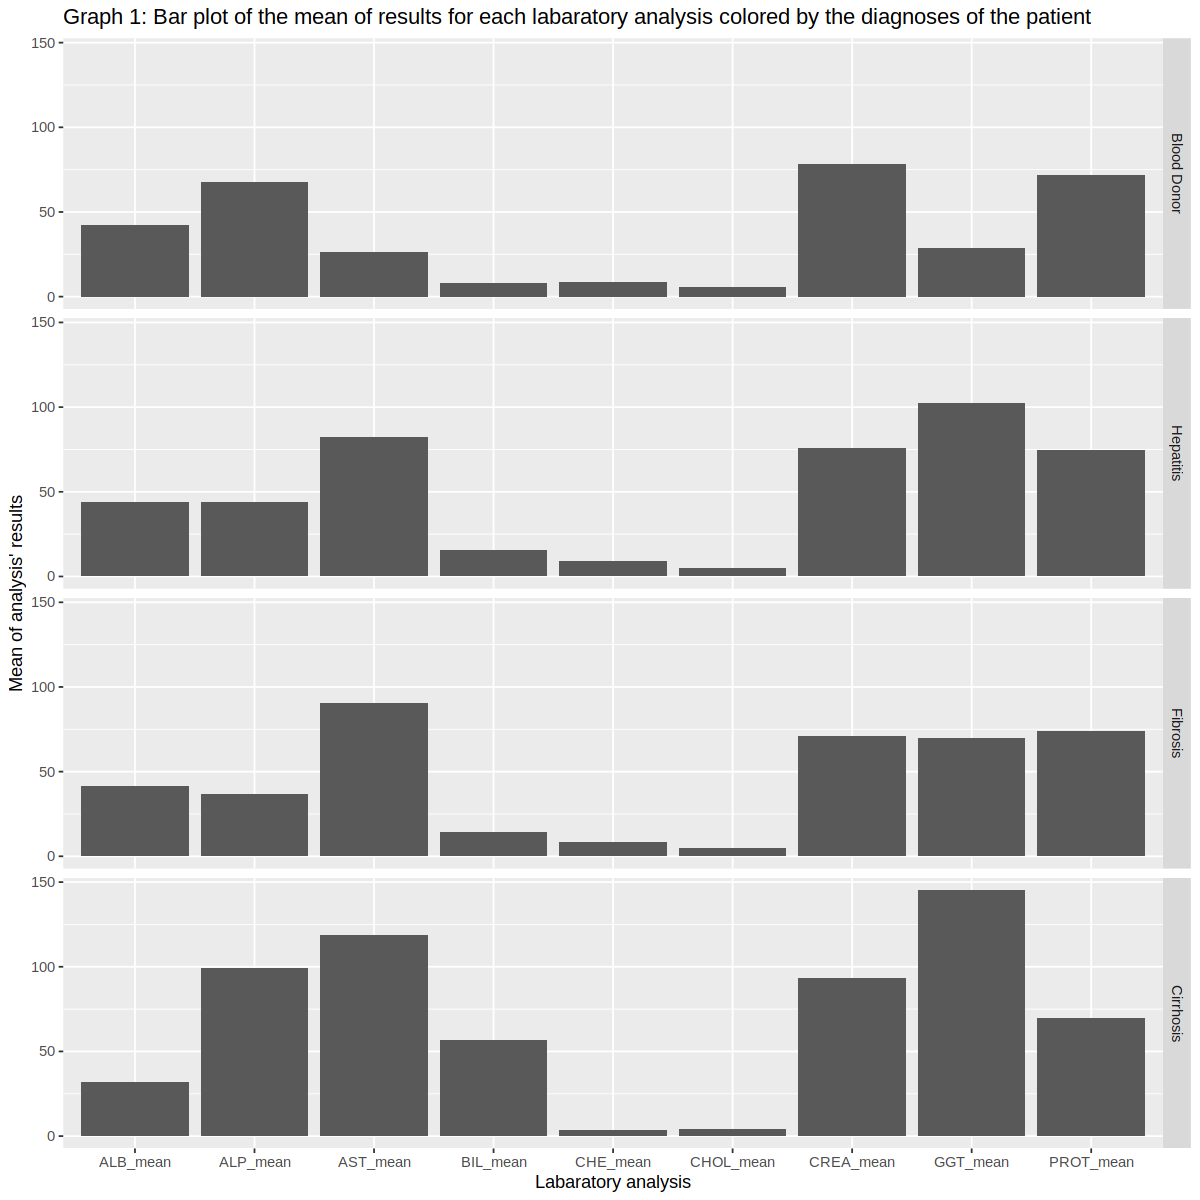

In [74]:
hcv_long <- hcv_train |>
pivot_longer(cols = ALB:PROT, names_to = "lab_result", values_to = "count") 

hcv_lab_summary_long <- hcv_lab_summary |>
pivot_longer(cols = ALB_mean:PROT_mean, names_to = "lab_result", values_to = "value") 

options(repr.plot.width = 10, repr.plot.height = 10) 
category_lab_result <- hcv_lab_summary_long |>
ggplot(aes(x = lab_result, y = value)) +
geom_bar(stat = "identity") + 
    facet_grid(rows = vars(Category))+
    xlab("laboratory analysis") + 
    ylab("Mean of analysis' results") +
    ggtitle("Graph 1: Bar plot of the mean of results for each laboratory analysis colored by the diagnoses of the patient")
category_lab_result

The visualization above contains 4 bar plots on the top of each other. Each bar plot represents one of for diagnoses, and shows the mean of results of each laboratory analysis. This visualisation helps us to compare the mean of each lab result based on the diagnoses. For example, we can see that the mean result for Bilirubin (BIL_mean) drastically increases when Fibrosis progresses into Cirrhosis.

**Methods:**

To choose the most useful variables, we need to conduct another 9 plots, each of which corresponds to a laboratory analysis. These plots may have four types of hepatitis C on the x-axis and one of the variables on the y-axis. Then use a scatter plot to show the distribution of different types on the graph. After comparing the nine plots, we will identify the most useful variables. 
To visualize the result, we are going to conduct a scatter plot that uses two or three most useful variables and is colored by four types of diagnosis. Finally, we will conduct classification to find the diagnosis for new observations.

Expected outcomes and significance:

- What do you expect to find?
- What impact could such findings have?
- What future questions could this lead to?

Citations:

Lichtinghagen,Ralf, Klawonn,Frank, and Hoffmann,Georg. (2020). HCV data. UCI Machine Learning Repository. https://doi.org/10.24432/C5D612.